This script is used for modeling pH of the particluar geochemical system

In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_error,r2_score

## The following are the ML models which can be used for trasinning
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler,StandardScaler

import timeit
import warnings
warnings.filterwarnings("ignore")


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
%matplotlib inline
import pandas as pd

In [3]:
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
sns.set_context('talk')

In [5]:
dataFolder = os.getcwd()
file = '10_PMU_02_LHS_500000_54854_02_t_P.dat' 
InsFile = os.path.join(dataFolder, file)
data = pd.read_csv(InsFile,sep ='\t')

In [6]:
data.columns =[col.strip() for col in data.columns]
data =data.iloc[:-1,:-1]

In [7]:
#data['Diff'] = data['totAcid'] - data['totBase']

In [8]:
data.head()

,mass_H2O,totU,totAcid,totBase,pH,U_aq,U_s,U_sc,U_ex,Kd_s,Kd_sc,Kd_ex,metaschoepite
0,0.999885,4.256100e-08,1.000000e-09,0.019946,12.167,4.589800e-09,3.797100e-08,3.797100e-08,8.980500e-27,8272.90000,8272.90000,1.956600e-15,0.000000
1,0.999916,4.718400e-03,1.000000e-09,0.002958,11.011,2.683400e-03,2.035300e-03,2.056400e-06,1.666000e-17,758.47000,0.76635,6.208600e-12,0.002033
2,0.999892,2.180700e-07,1.000000e-09,0.019102,12.148,2.462500e-08,1.934400e-07,1.934400e-07,5.718700e-26,7855.70000,7855.70000,2.322300e-15,0.000000
3,0.999817,6.536800e-03,1.000000e-09,0.014391,11.743,6.536000e-03,2.006400e-06,2.006400e-06,2.907300e-19,0.30697,0.30697,4.448100e-14,0.000000
4,0.999961,6.481000e-06,1.000000e-09,0.011462,11.928,4.551300e-06,1.929900e-06,1.929900e-06,7.580100e-23,424.03000,424.03000,1.665500e-14,0.000000


## Four gorups

### Group1: acid with metaschoepite

### Group2: acid without metaschoepite
### Group3: base with metaschoepite
### Group4: base without metaschoepite


In [9]:
conds = [((data['metaschoepite']>0) & (data['totAcid']>1.0e-9)),
              ((data['metaschoepite']==0) & (data['totAcid']>1.0e-9)),
              ((data['metaschoepite']>0) & (data['totAcid']<=1.0e-9)),
              ((data['metaschoepite']==0) & (data['totAcid']<=1.0e-9)),
]
groups = ['group1','group2','group3','group4']

data['group'] =np.select(conds, groups)


In [18]:
data.groupby('group').count()

,mass_H2O,totU,totAcid,totBase,pH,U_aq,U_s,U_sc,U_ex,Kd_s,Kd_sc,Kd_ex,metaschoepite,ratio
group,,,,,,,,,,,,,,
group1,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764,2764
group2,247235,247235,247235,247235,247235,247235,247235,247235,247235,247235,247235,247235,247235,247235
group3,8852,8852,8852,8852,8852,8852,8852,8852,8852,8852,8852,8852,8852,8852
group4,241148,241148,241148,241148,241148,241148,241148,241148,241148,241148,241148,241148,241148,241148


In [10]:
## calculate the ratio totU to totAcid or totBase
data['ratio'] = data.apply(lambda row: row['totU']/row['totAcid'] if row['group'] in ['group1','group2'] else
                                  row['totU']/row['totBase'],axis=1)

In [11]:
def draw1to1plots(ax,df,yVar,xVar,scale='log'):
    
    colors= ['r','k','c','g']
    markers = ['o','^','D','s']
    for i,group in enumerate(df['group'].unique()):
        df2 =df[df['group']==group]
        ax.scatter(df2[xVar].values,df2[yVar].values,color=colors[i],marker = markers[i],
                   s=5,label=group + ': '+xVar + '=>' + yVar)
        ax.set_ylabel(yVar)
        ax.set_xlabel(xVar)
        #ax.legend (loc='best')
        if scale=='log':
            ax.set_yscale('log')
        ax.set_xscale('log')
        

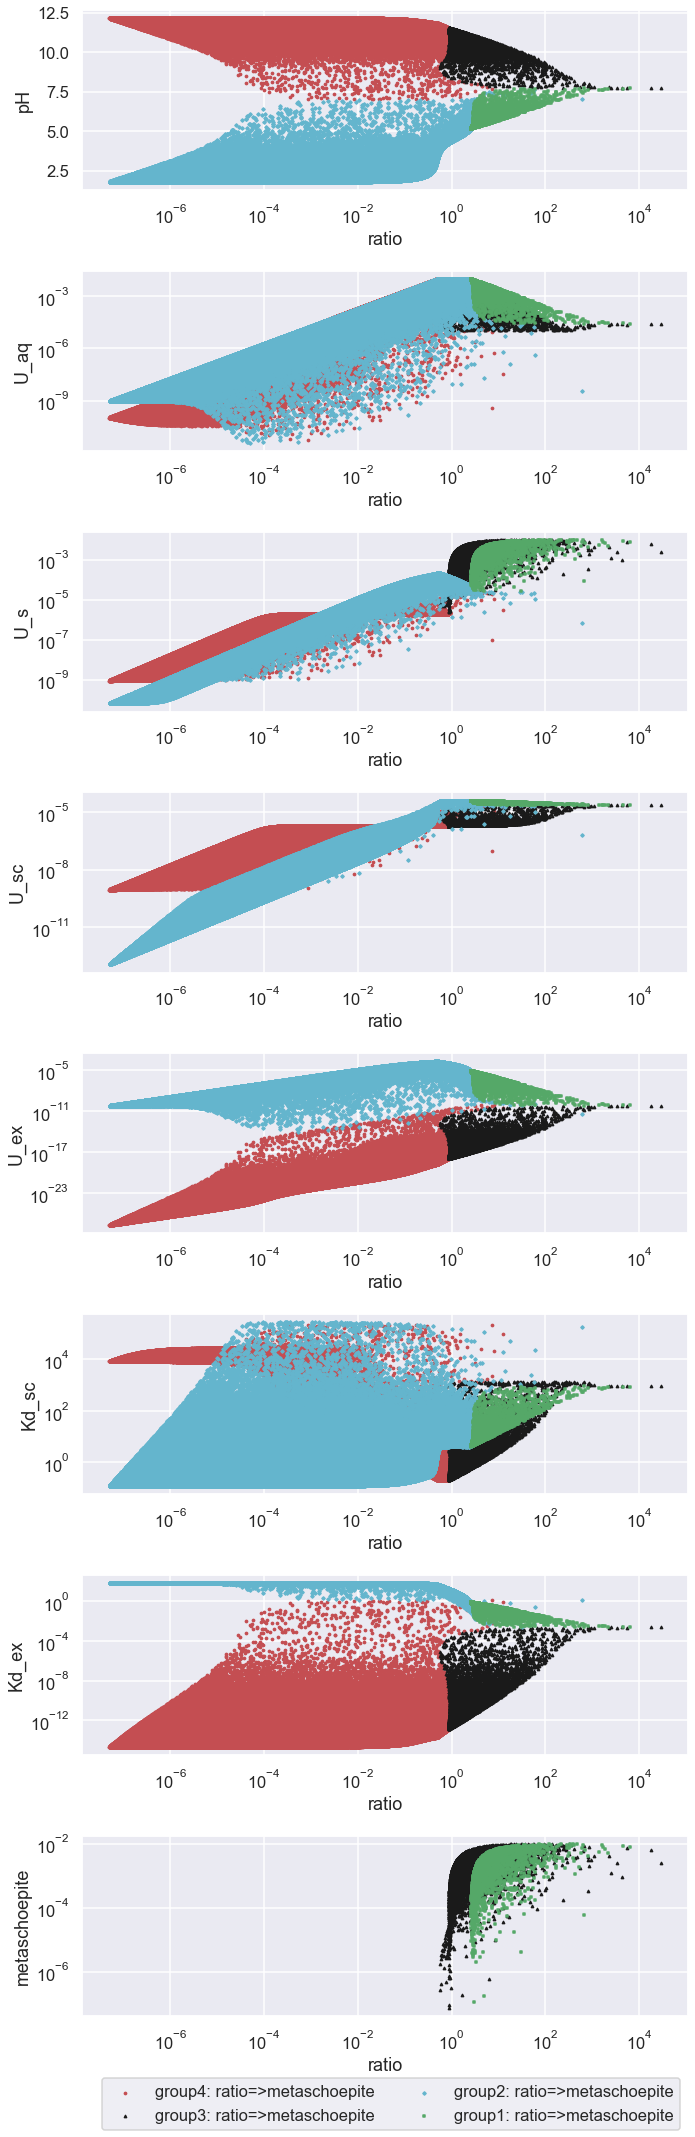

In [12]:
xVars = [ 'ratio']
yVars = ['pH', 'U_aq', 'U_s', 'U_sc', 'U_ex', 'Kd_sc', 'Kd_ex', 'metaschoepite']
fig,ax =plt.subplots(len(yVars),len(xVars),figsize =(10,30))
scales = ['no','log','log','log','log','log','log','log'] 
for i,yVar in enumerate(yVars):
    for j,xVar in enumerate(xVars):
        df = data.loc[:,[xVar,yVar,'group']]
           
        draw1to1plots(ax[i],df,yVar,xVar,scale=scales[i])
        '''
        if j==0 and i<len(yVars)-1:
            #ax[i,j].axes.get_yaxis().set_visible(False)
            ax[j].axes.get_xaxis().set_ticklabels([])
            #ax[i,j].set_xlabel("")
        if j>0 and i<len(yVars)-1:
            #ax[i,j].set_xlabel("")
            ax[j].axes.get_xaxis().set_ticklabels([])
            ax[j].set_ylabel("")
            ax[j].axes.get_yaxis().set_ticklabels([])
        if j>0 and i==len(yVars)-1:
            ax[j].set_ylabel("")
            ax[j].axes.get_yaxis().set_visible(False)
        
        '''
ax[i].legend(bbox_to_anchor=(1.0, -0.3),ncol=2)       
fig.tight_layout()     

## Look into each of the four groups

In [13]:
def draw1to1groupplots(ax,df,yVar,xVar,group,color='b',scale='log'):
    
    ax.scatter(df[xVar].values,df[yVar].values,color=color,marker = 'o',s = 5)
    ax.set_ylabel(yVar)
    ax.set_xlabel(xVar)
    #ax.legend (loc='best')
    if scale=='log':
        ax.set_yscale('log')
    ax.set_xscale('log')
    

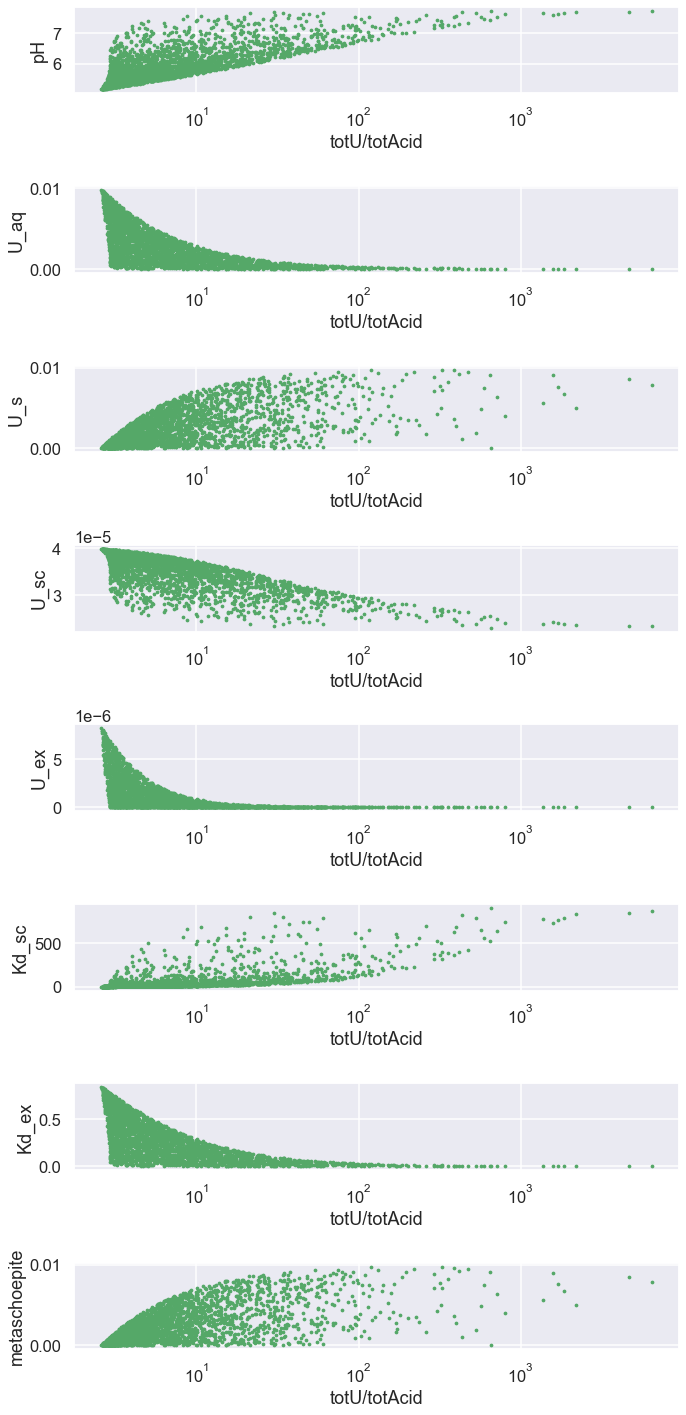

In [14]:
group ='group1'
df = data[data['group']==group]
df['totU/totAcid'] = df['totU']/df['totAcid']
xVars = ['totU/totAcid']
yVars = ['pH', 'U_aq', 'U_s', 'U_sc', 'U_ex', 'Kd_sc', 'Kd_ex', 'metaschoepite']
scales = ['no','log','log','log','log','log','log','log'] 

fig,ax =plt.subplots(len(yVars),len(xVars),figsize =(10,20))

for i,yVar in enumerate(yVars):
    for j,xVar in enumerate(xVars):
        df1 = df.loc[:,[xVar,yVar]]
        #colors= ['r','k','c','g']
        draw1to1groupplots(ax[i],df1,yVar,xVar,group,color='g',scale='no') #scales[i])
        '''
        if j==0 and i<len(yVars)-1:
            #ax[i,j].axes.get_yaxis().set_visible(False)
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            #ax[i,j].set_xlabel("")
        if j>0 and i<len(yVars)-1:
            #ax[i,j].set_xlabel("")
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_ticklabels([])
        if j>0 and i==len(yVars)-1:
            #ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_visible(False)
       ''' 
        
fig.tight_layout()     

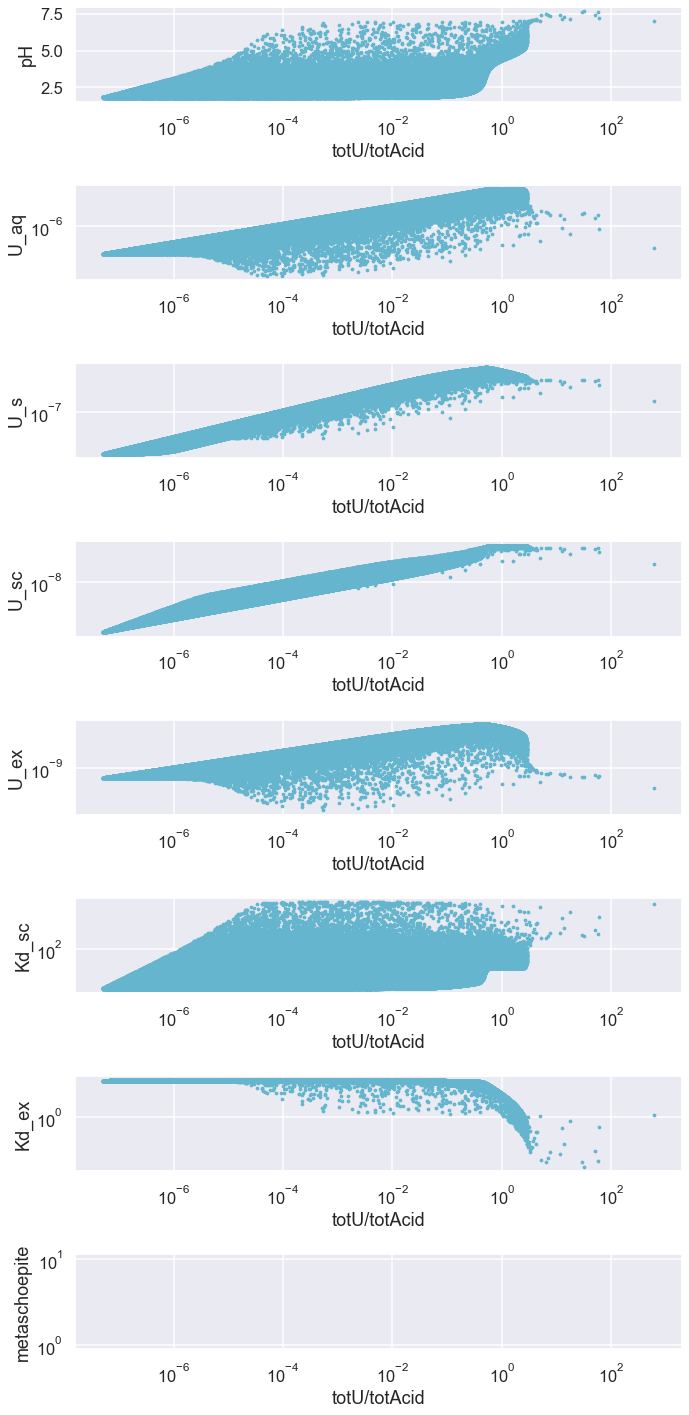

In [15]:
group ='group2'
df = data[data['group']==group]
df['totU/totAcid'] = df['totU']/df['totAcid']
xVars = ['totU/totAcid']
yVars = ['pH', 'U_aq', 'U_s', 'U_sc', 'U_ex', 'Kd_sc', 'Kd_ex', 'metaschoepite']
scales = ['no','log','log','log','log','log','log','log'] 

fig,ax =plt.subplots(len(yVars),len(xVars),figsize =(10,20))

for i,yVar in enumerate(yVars):
    for j,xVar in enumerate(xVars):
        df1 = df.loc[:,[xVar,yVar]]
        draw1to1groupplots(ax[i],df1,yVar,xVar,group,color='c',scale=scales[i])
        '''
        if j==0 and i<len(yVars)-1:
            #ax[i,j].axes.get_yaxis().set_visible(False)
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            #ax[i,j].set_xlabel("")
        if j>0 and i<len(yVars)-1:
            #ax[i,j].set_xlabel("")
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_ticklabels([])
        if j>0 and i==len(yVars)-1:
            #ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_visible(False)
       ''' 
        
fig.tight_layout() 

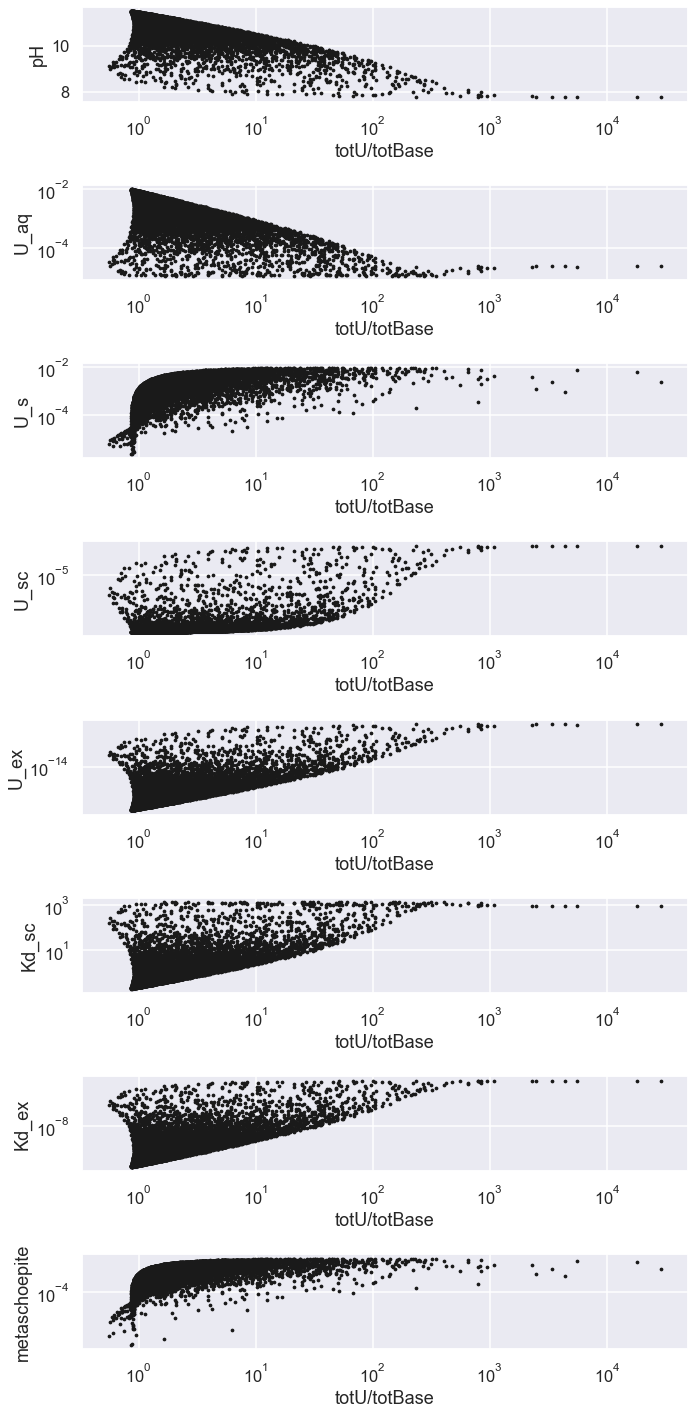

In [16]:
group ='group3'
df = data[data['group']==group]
df['totU/totBase'] = df['totU']/df['totBase']
xVars = ['totU/totBase']
yVars = ['pH', 'U_aq', 'U_s', 'U_sc', 'U_ex', 'Kd_sc', 'Kd_ex', 'metaschoepite']
scales = ['no','log','log','log','log','log','log','log'] 

fig,ax =plt.subplots(len(yVars),len(xVars),figsize =(10,20))

for i,yVar in enumerate(yVars):
    for j,xVar in enumerate(xVars):
        df1 = df.loc[:,[xVar,yVar]]

        draw1to1groupplots(ax[i],df1,yVar,xVar,group,color='k',scale=scales[i])
        '''
        if j==0 and i<len(yVars)-1:
            #ax[i,j].axes.get_yaxis().set_visible(False)
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            #ax[i,j].set_xlabel("")
        if j>0 and i<len(yVars)-1:
            #ax[i,j].set_xlabel("")
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_ticklabels([])
        if j>0 and i==len(yVars)-1:
            #ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_visible(False)
       ''' 
        
fig.tight_layout() 

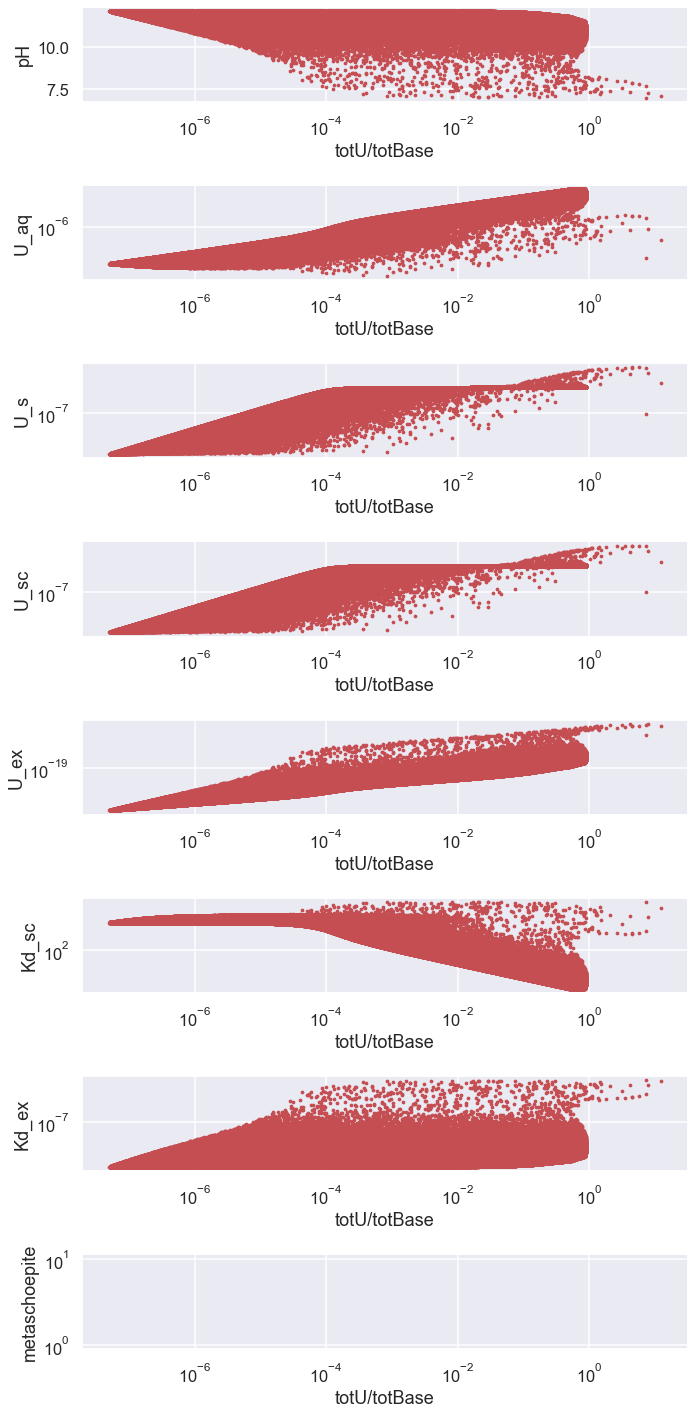

In [17]:
group ='group4'
df = data[data['group']==group]
df['totU/totBase'] = df['totU']/df['totBase']
xVars = ['totU/totBase']
yVars = ['pH', 'U_aq', 'U_s', 'U_sc', 'U_ex', 'Kd_sc', 'Kd_ex', 'metaschoepite']
scales = ['no','log','log','log','log','log','log','log'] 

fig,ax =plt.subplots(len(yVars),len(xVars),figsize =(10,20))

for i,yVar in enumerate(yVars):
    for j,xVar in enumerate(xVars):
        df1 = df.loc[:,[xVar,yVar]]
        draw1to1groupplots(ax[i],df1,yVar,xVar,group,color='r',scale=scales[i])
        '''
        if j==0 and i<len(yVars)-1:
            #ax[i,j].axes.get_yaxis().set_visible(False)
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            #ax[i,j].set_xlabel("")
        if j>0 and i<len(yVars)-1:
            #ax[i,j].set_xlabel("")
            ax[i,j].axes.get_xaxis().set_ticklabels([])
            ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_ticklabels([])
        if j>0 and i==len(yVars)-1:
            #ax[i,j].set_ylabel("")
            ax[i,j].axes.get_yaxis().set_visible(False)
       ''' 
        
fig.tight_layout() 